# Dublin Air Pollution
#### [ Programming for Data Analysis Project GMIT 2020 ]
<br>

<img align="left" width="340" src="http://airtoxenviro.com/wp-content/uploads/2015/05/Power-Plant-Clip-Art.png">

<br><br><br><br><br><br><br><br><br><br><br><br><br><br>
_Completed by:_ Olga Rozhdestvina (G00387844@gmit.ie)

___
<br>

## Table of Contents
* [Overview](#overview)
* [General Setup](#setup)
* [Original Data](#original_data)
* [Analysis of the Data Set](#analysis)
    * [Pollution](#pollutants)
    * [Wind](#wind)
    * [Correlation Between Variables](#correlation)
        * [Pollution vs Time](#pol_vs_time)
        * [Wind speed vs Time](#wind_vs_time)
        * [Pollution vs Wind Speed](#pol_vs_wind)
* [Distribution Fitting](#dist_fitting)
* [Data Simulation](#data_simulation)
* [Simulated Data Set](#new_ds)
* [Comparison between Simulated and Original data sets](#comparison)
    * [Visualization](#vis)
    * [Mean](#mean)
    * [Variance](#variance)
* [Final Adjustments](#adj)

<br>

### Overview <a href="overview"></a>
___

<br>

Air pollution is a mixture of solid and gas particles in the air. Every year it causes approximately seven million premature deaths [1]. As air pollution levels increase, there has been a growing interest in modelling the relationship between atmospheric concentration of pollutants and various meteorological conditions in the area studied. [2]

The Air Quality Index, or AQI, is used for measuring the real-time pollution. The higher it is, the greater the level of air pollution. AQI is based on measurement of:

* **NO2** - nitrogen dioxide, 
* **PM10** - particulate matter with a diameter of less than 2.5 micrometers,
* **PM2.5** - particulate matter with a diameter of less than 2.5 micrometers,
* **O3** - ozone,
* **SO2** - sulfur dioxide.

There is a number of meteorological factors that affect AQI. In my analysis I will be looking at wind speed and direction. 

Variables measured for this project: _AQI_ variable is a non-negative integer, _NO2, PM10, PM2.5, O3, SO2, Wind_ are non-negative real numbers with one decimal place and _Wind Direction_ is categorical variable with four possible values: west, north east, north, north west.

> [1] [WHO: Air Pollution](https://www.who.int/health-topics/air-pollution#:~:text=The%20combined%20effects%20of%20ambient,cancer%20and%20acute%20respiratory%20infections.)
<br>
[2] [Joanna A. Kaminska: Probabilistic Forecasting of Nitrogen Dioxide Concentrations at an Urban Road Intersection](https://www.researchgate.net/publication/328978359_Probabilistic_Forecasting_of_Nitrogen_Dioxide_Concentrations_at_an_Urban_Road_Intersection)

<br>

### General Setup  <a name="setup"></a>
___

<br>

In [1]:
# Dataframes.
import pandas as pd
# To register the converters
from pandas.plotting import register_matplotlib_converters

# Calculations and distributions.
import numpy as np

# Distribution fitting.
from scipy import stats
# Alternative statistics package.
import statsmodels.stats.weightstats as stat

# Plotting.
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Register converters and inline plots.
register_matplotlib_converters()
%matplotlib inline

In [2]:
# Colour scheme and styles for plots.
sns.set_theme(palette="Set2", context="paper", font_scale=1.5)

# Better sized plots.
plt.rcParams['figure.figsize'] = (13, 9)

<br>

### Original Data  <a name="original_data"></a>
___

<br>

I have collected data on air pollution in Dublin for 07/12/2020 from [IQAir](https://www.iqair.com/) - a website of a Swiss air quality technology company. [3] Data on wind speed and direction was collected from [Met Eireann Forecast](https://www.met.ie/) [4]


> [3] [IQAir: Air quality in Dublin](https://www.iqair.com/us/ireland/leinster/dublin)
<br>
[4] [Met Eireann Forecast in Dublin City](https://www.met.ie/weather-forecast/dublin-city#forecasts)

In [3]:
# Create the date range for 24 hours.
rng = pd.date_range('12/07/2020', periods=24, freq='H')

In [4]:
# Original data.
raw_data = {'AQI': [84,74,74,72,72,72,72,72,71,72,72,73,80,74,74,74,74,74,74,76,72,76,68,67],
            'NO2': [32.1,29.7,28.5,26.9,26.1,25.8,26.5,27.3,30.9,41.1,52,55.1,58.3,52,41.7,42.6,41.9,38.7,43.1,37.5,32.4,28.7,27.2,20.6],
            'PM2.5': [28,23,23,22.1,22.2,22.1,22,21.9,21.8,22,22.2,22.4,25.9,23,23.1,23.2,23.1,23.1,22.9,24,22.3,24.1,20.1,19.7],
            'PM10': [36,33,28.1,21.2,21.5,19.8,17.1,16.4,15.1,16.6,21.2,28.6,31.1,25.7,25.5,24.4,30.9,25.9,30.9,32.8,30.7,26.6,21.3,18.4],
            'O3': [1,0.4,0.8,0.4,0.3,0.4,0.7,0.3,0,0.6,0.7,0,0.8,0.8,1.8,1.5,1.1,0.8,0.9,0.8,0.7,1.8,3,4.6],
            'SO2': [5,4.2,4.1,3.9,3.7,4.3,4.8,4.2,4.6,6.6,8.2,9.2,10.6,8.6,6.7,6.8,6.9,6,6.3,5,3.6,4.1,4.1,3.4],
            'Wind': [9,9,9,7,7,7,7,7,6,7,7,9,17,15,15,19,13,17,17,19,19,19,19,22],
            'Wind Direction': ['west','west','west','north west','north west','west','north west','north west','north west','north west','north east','north west','north','north','north west','north west','north west','north west','west','west','west','west','west','west']
           }


# Create a dataframe.
df = pd.DataFrame(raw_data, index=rng)

# Display the dataframe.
df

,AQI,NO2,PM2.5,PM10,O3,SO2,Wind,Wind Direction
2020-12-07 00:00:00,84,32.1,28.0,36.0,1.0,5.0,9,west
2020-12-07 01:00:00,74,29.7,23.0,33.0,0.4,4.2,9,west
2020-12-07 02:00:00,74,28.5,23.0,28.1,0.8,4.1,9,west
2020-12-07 03:00:00,72,26.9,22.1,21.2,0.4,3.9,7,north west
2020-12-07 04:00:00,72,26.1,22.2,21.5,0.3,3.7,7,north west
2020-12-07 05:00:00,72,25.8,22.1,19.8,0.4,4.3,7,west
2020-12-07 06:00:00,72,26.5,22.0,17.1,0.7,4.8,7,north west
2020-12-07 07:00:00,72,27.3,21.9,16.4,0.3,4.2,7,north west
2020-12-07 08:00:00,71,30.9,21.8,15.1,0.0,4.6,6,north west
2020-12-07 09:00:00,72,41.1,22.0,16.6,0.6,6.6,7,north west


<br>

### Analysis of the data set <a name="analysis"></a>
___

Prior to visualizing our data it would be wise to view our data through some basic statistical details on numerical variables in our data set.

In [5]:
df.describe()

,AQI,NO2,PM2.5,PM10,O3,SO2,Wind
count,24.000000,24.000000,24.00000,24.000000,24.000000,24.000000,24.000000
mean,73.458333,36.112500,22.80000,24.950000,1.008333,5.620833,12.583333
std,3.387691,10.507609,1.64766,6.052308,1.004302,1.975498,5.428721
min,67.000000,20.600000,19.70000,15.100000,0.000000,3.400000,6.000000
25%,72.000000,27.275000,22.07500,20.850000,0.400000,4.100000,7.000000
50%,73.500000,32.250000,22.65000,25.600000,0.800000,4.900000,11.000000
75%,74.000000,42.075000,23.10000,30.750000,1.025000,6.725000,17.500000
max,84.000000,58.300000,28.00000,36.000000,4.600000,10.600000,22.000000


It is clear from the table above that the highest concentration belongs to _NO2_.

<br>

#### Pollution <a name="pollutants"></a> 

<br>

First we should plot the pollution related data on that day. [5]

> [5] [Stack Overflow: Pandas: Sort column by maximum values](https://stackoverflow.com/questions/40111161/pandas-sort-column-by-maximum-values)

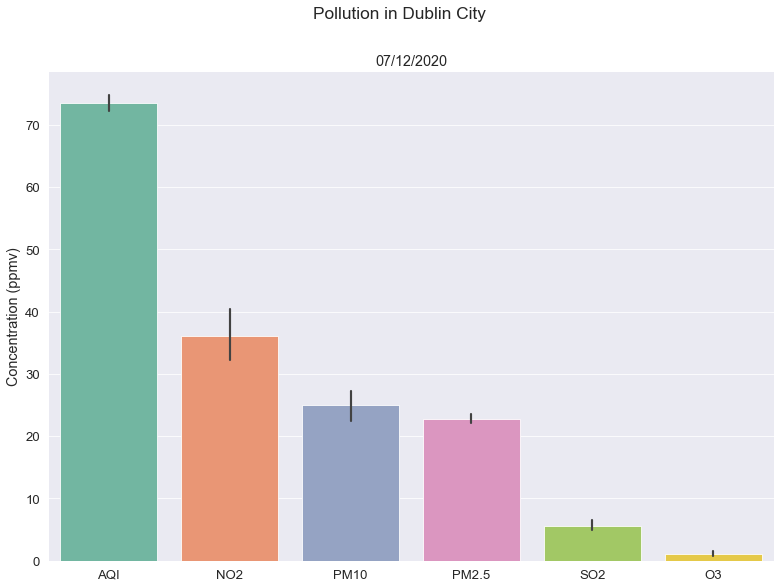

In [6]:
# Separate pollution values.
pollution = df[['AQI','NO2','PM2.5','PM10','O3','SO2']]

# Sort them by maximum value.
sorted_pol = pollution.loc[:, pollution.max().sort_values(ascending=False).index]

# Create a figure and axis.
fig, ax = plt.subplots()

# Set titles and y label.
fig.suptitle("Pollution in Dublin City")
ax.set_ylabel("Concentration (ppmv)")

# Plot the data ordered by maximum and set a small title.
sns.barplot(data=pollution, order=list(sorted_pol), ax=ax).set_title("07/12/2020")

# Show plot.
plt.show()

And now let's look at the pollutant concentration in percentages. [6] [7]

> [6] [GeeksforGeeks: How to get column names in Pandas dataframe](https://www.geeksforgeeks.org/how-to-get-column-names-in-pandas-dataframe/)
<br>
[7] [Matplotlib: Basic pie chart](https://matplotlib.org/3.3.3/gallery/pie_and_polar_charts/pie_features.html#sphx-glr-gallery-pie-and-polar-charts-pie-features-py)

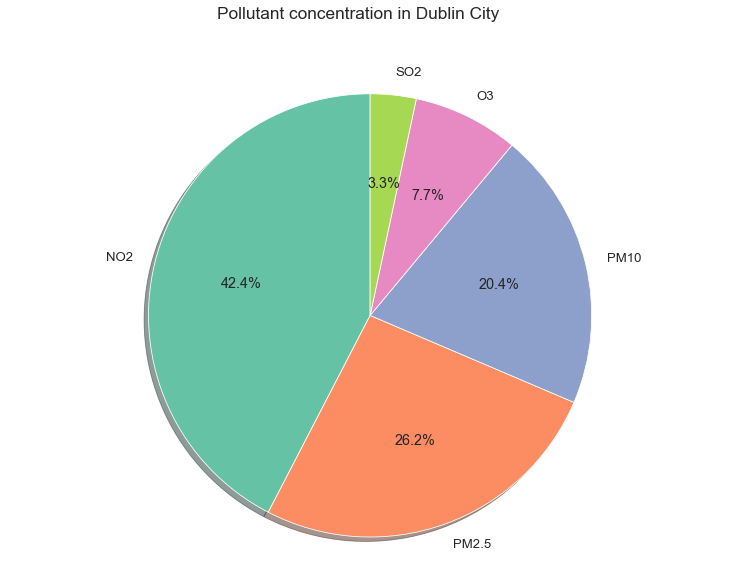

In [7]:
# Calculate maximum values of each pollutant and set as pie sizes, set pollutant names as labels
sizes = [df['NO2'].max(), df['PM10'].max(), df['PM2.5'].max(), df['SO2'].max(), df['O3'].max()]
labels = [col for col in pollution.columns][1:]

# Create a figure and axis, set a title.
fig, ax = plt.subplots()
fig.suptitle("Pollutant concentration in Dublin City")

# Build a pie plot.
ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal') 

# Show the plot.
plt.show()

<br>

The above plots confirm that the primary pollutant in Dublin is _NO2_. The next in line are _PM10_ and _PM2.5_ , whereas _SO2_ is fairly low and _O3_ is almost non-existent.

Next we should view how each pollutant and AQI are distributed. [8]

> [8] [Stack Overflow: Matplotlib subplots_adjust hspace so titles and xlabels don't overlap?
](https://stackoverflow.com/questions/2418125/matplotlib-subplots-adjust-hspace-so-titles-and-xlabels-dont-overlap)

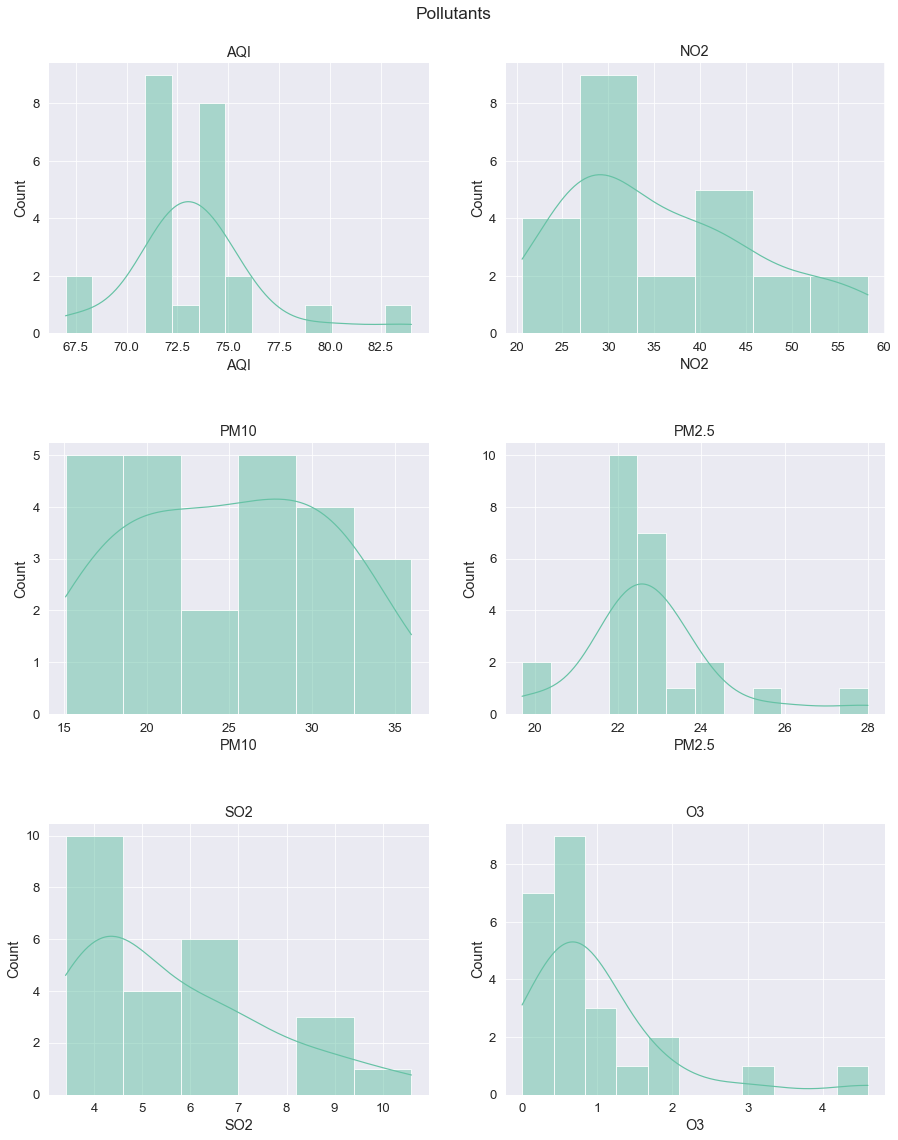

In [8]:
# Create a figure and a set of subplots 3x2 and change plot size.
fig, [[ax1, ax2],[ax3,ax4],[ax5,ax6]] = plt.subplots(3,2, figsize=(15,19))

# Set a title.
fig.suptitle("Pollutants", y=0.92)

# Adjust subplots so the title don't overlap.
plt.subplots_adjust(hspace=0.4)

def hist(data, ax):
    """ Fuction to build a histogram"""
    # Plot data.
    sns.histplot(df[data], kde=True, ax=ax)
    # Set title.
    ax.set_title(f"{data}")

# Plot the data.
hist('AQI',ax1)
hist('NO2',ax2)
hist('PM10',ax3)
hist('PM2.5',ax4)
hist('SO2',ax5)
hist('O3',ax6)

# Show the plots.
plt.show()

<br>

Judging by the shape of the distribution the data doesn't appear to be normally distributed and it is difficult to say which type of distribution will fit any of the variables with any degree of certainty.

<br>

#### Wind <a name="wind"></a> 

<br>

Following the structure above, we can build plots for Wind related data.

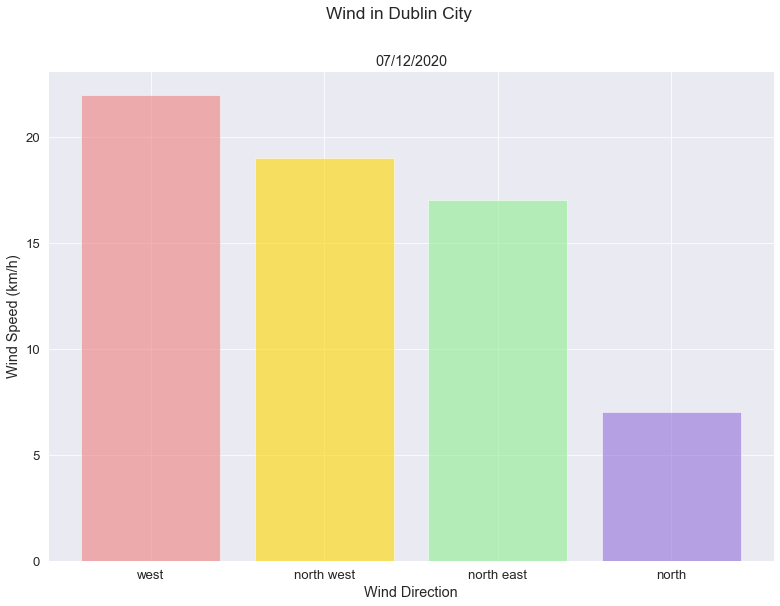

In [9]:
# Separate wind related values.
wind = df[['Wind', "Wind Direction"]]

# Select unique values.
labels = wind["Wind Direction"].unique()

# Calculate maximum speed for each wind drection
west = (wind.loc[wind.loc[:, 'Wind Direction'] == 'west']).max()
north_west = (wind.loc[wind.loc[:, 'Wind Direction'] == 'north west']).max()
north_east = (wind.loc[wind.loc[:, 'Wind Direction'] == 'north east']).max()
north = (wind.loc[wind.loc[:, 'Wind Direction'] == 'north']).max()

# Create an array from the calculations
values = [west[0], north_west[0], north_east[0], north[0]]

# Sort in a descending manner.
values.sort(reverse=True)

# Create a figure and axis
fig, ax = plt.subplots()

# Set titles and axis labels
fig.suptitle("Wind in Dublin City")
ax.set_title("07/12/2020")
ax.set_xlabel("Wind Direction")
ax.set_ylabel("Wind Speed (km/h)")

# Plot data.
ax.bar(labels, values, color=['lightcoral', 'gold', 'lightgreen', 'mediumpurple'], alpha=.6)

# Show plot.
plt.show()

<br>

The plot shows that the strongest wind during 7th December was of west direction.

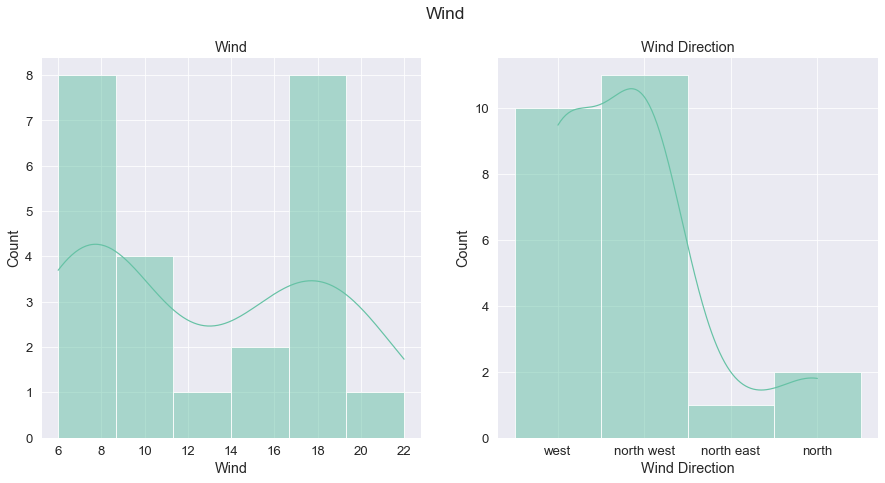

In [10]:
# Create a figure and a set of subplots 1x2.
fig, [ax1,ax2] = plt.subplots(1,2, figsize=(15, 7))

# Set a title.
fig.suptitle("Wind")

# Plot wind data.
hist("Wind",ax1)
hist("Wind Direction",ax2)

# Show the plot.
plt.show()

<br>

Once again the data plotted above doesn't appear to be normally distributed and without fitting a distribution it is hard to tell which type will be the best fit to the data.


<br>

#### Correlation Between Variables <a name="correlation"></a> 

<br>

In statistics, the relationship between two variables is referred to as their correlation. It can be useful in our analysis and modeling to better understand the relationships between pollutant concentration, time of the day and wind speed. [9]

> [9] [Stack Overflow: how to get ticks every hour?](https://stackoverflow.com/questions/48790378/how-to-get-ticks-every-hour) 


<br>

##### Pollution vs Time  <a name="pol_vs_time"></a> 

<br>

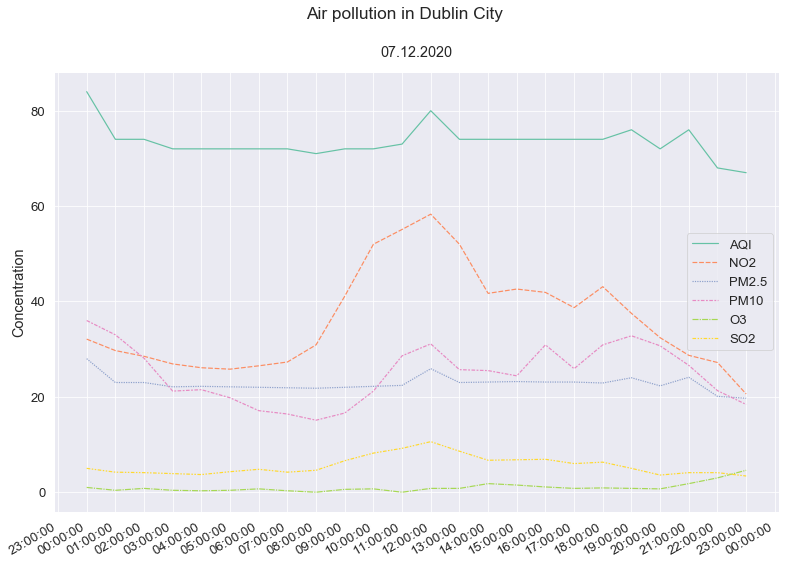

In [11]:
def lineplot(data, suptitle, label):
    """ Building lineplot function """
    
    # Create a figure and axis.
    fig, ax = plt.subplots()    
    # Set a title and a label for y axis.
    fig.suptitle(suptitle)
    ax.set_ylabel(label)
    
    # Plot data.
    sns.lineplot(data=data,ax=ax).set_title("07.12.2020", y=1.02)
    
    # Make the x axis display well.
    hours = mdates.HourLocator(interval = 1)
    h_fmt = mdates.DateFormatter('%H:%M:%S')
    # Tick ax axis.
    ax.xaxis.set_major_locator(hours)
    ax.xaxis.set_major_formatter(h_fmt)
    # Format.
    fig.autofmt_xdate()
    
    # Show the plot.
    plt.show()

# Plot pollution data.
lineplot(pollution, "Air pollution in Dublin City", "Concentration")   

<br>

The plot depicts relationship between concentration of NO2, PM10 and SO2 and time of the day: it start rising from 7-8 am, reaches its peack at 12 pm and then again at 6-7 pm and starts falling after 7 pm. 
In my opinion, what explains such trend is that the most of the pollutants in Dublin primarily get in the air from cars, trucks and buses emissions, power plants, and off-road equipment. Thus the pollution concentration rises and falls with traffic.

There are many other factors that influence pollution concentration. For example, PM10 and PM2.5 are both influenced by the atmospheric conditions like wind (we will be looking into it later). Other factors, such as energy consumption and the proportion of electricity consumption contribute to PM2.5 level. [10]


> [10] [Springer Link: Influence of the atmospheric conditions on PM10 concentrations in Poznań, Poland](https://link.springer.com/article/10.1007/s10874-016-9345-5)

<br>

##### Wind speed vs Time  <a name="wind_vs_time"></a> 

<br>

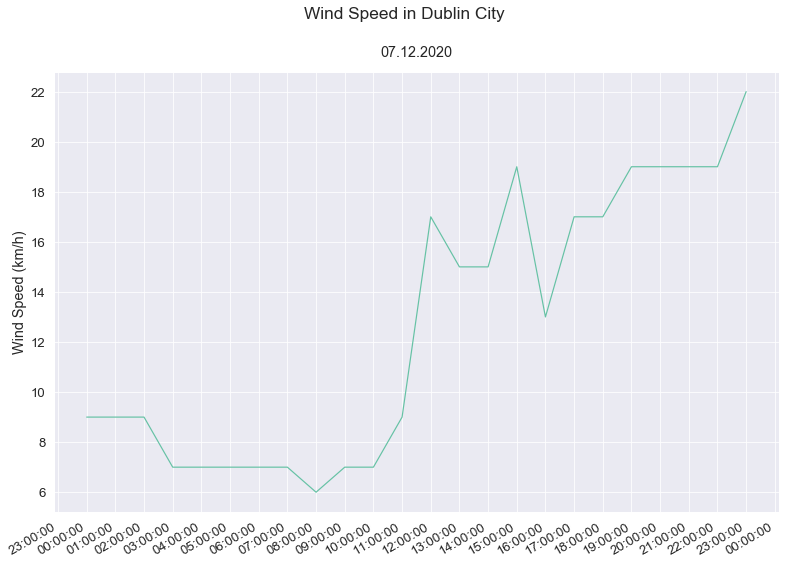

In [12]:
# Plot wind data.
lineplot(df["Wind"], "Wind Speed in Dublin City", "Wind Speed (km/h)")

<br>

The graph shows that between midnight and 11 am it was time of relatively low wind speeds (below 10 km/h). From 11 am the wind speed continued increasing with a few drops in speed until it reached its peak at 11 pm. 

<br>

##### Pollution vs Wind Speed <a name="pol_vs_wind"></a>

<br>

Now that we have looked at relashionship with time, we can investigate correlation between pollution variables and wind speed. [11]

> [11] [Real Python: NumPy, SciPy, and Pandas: Correlation With Python](https://realpython.com/numpy-scipy-pandas-correlation-python/#example-scipy-correlation-calculation)

<br>

* __NO2__

In [13]:
def correlation(pollutant, var):
    """ Correlation calculation """
    # Pearson’s r.
    cf1, p1 = stats.pearsonr(df[pollutant], df[var])
    # Spearman’s rho.
    cf2, p2 = stats.spearmanr(df[pollutant], df[var])
    # Kendall’s tau.
    cf3, p3 = stats.kendalltau(df[pollutant], df[var])
    # print correlation coefficients and p-values to two decimal points.
    print(f"Pearson’s r: {cf1:.2f}, p-value: {p1:.2f}")
    print(f"Spearman’s rho: {cf2:.2f}, p-value: {p2:.2f}")
    print(f"Kendall’s tau: {cf3:.2f}, p-value: {p3:.2f}")

# Calculate correlation between NO2 and Wind Speed.
correlation("NO2", "Wind")

Pearson’s r: 0.12, p-value: 0.59
Spearman’s rho: 0.19, p-value: 0.38
Kendall’s tau: 0.13, p-value: 0.39


In these results, all three correlation coefficients are indicating weak positive relationship between NO2 and wind speed. However, they are not statistically significant since p-value in all three cases is above 0.05 [12] [13]

> [12] [Statistical Help: P Values](https://www.statsdirect.com/help/basics/p_values.htm)
<br>
[13] [Minitab Express Support: Interpret the key results for Correlation](https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/how-to/correlation/interpret-the-results/#:~:text=For%20the%20Pearson%20correlation%2C%20an,linear%20relationship%20between%20the%20variables.&text=If%20both%20variables%20tend%20to,represents%20the%20correlation%20slopes%20upward)

<br>

* __PM10__

In [14]:
# Calculate correlation between PM10 and Wind Speed.
correlation("PM10", "Wind")

Pearson’s r: 0.36, p-value: 0.08
Spearman’s rho: 0.47, p-value: 0.02
Kendall’s tau: 0.33, p-value: 0.03


Here we can see that Spearman’s and Kendall’s correlation coefficients are statistically significant (with p-value is below 0.05) and both indicate moderate positive relationship between PM10 and wind speed. [14] [15]

> [14] [Stack Overflow: How to Scatter plot or heatmap spearman's correlation in python?](https://stackoverflow.com/questions/62201732/how-to-scatter-plot-or-heatmap-spearmans-correlation-in-python)
<br>
[15] [Stack Exchange: seaborn heatmap not displaying correctly](https://datascience.stackexchange.com/questions/57245/seaborn-heatmap-not-displaying-correctly)

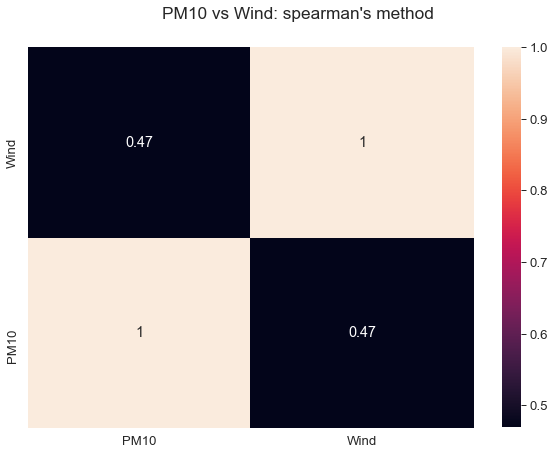

In [15]:
def plot_corr(pollutant, var, method):
    """ Plot correlation heatmap"""
    
    # Create a figure and axis.
    fig, ax = plt.subplots(figsize=(10, 7))
    # Create a Dataframe for plotting.
    df_corr = pd.DataFrame({pollutant: df[pollutant], var: df[var]})
    # Calculate correlation with pandas.
    corr = df_corr.corr(method = method)
    
    # Build a plot.
    sns.heatmap(corr, annot=True, ax=ax)
    
    # Set a title.
    fig.suptitle(f"{pollutant} vs {var}: {method}'s method", y=0.96)
    # Set y limits so the annotations are shown correctly.
    plt.ylim(0,2)
    
    # Show the plot.
    plt.show()
    

# Plot PM10 vs Wind with Spearman’s method.
plot_corr("PM10", "Wind", "spearman")

<br>

* __PM2.5__

In [16]:
# Calculate correlation between PM2.5 and Wind Speed.
correlation("PM2.5", "Wind")

Pearson’s r: 0.01, p-value: 0.96
Spearman’s rho: 0.39, p-value: 0.06
Kendall’s tau: 0.37, p-value: 0.02


In case of PM2.5, only Kendall's tau is statistically significant and indicate moderate positive relationship with wind speed.

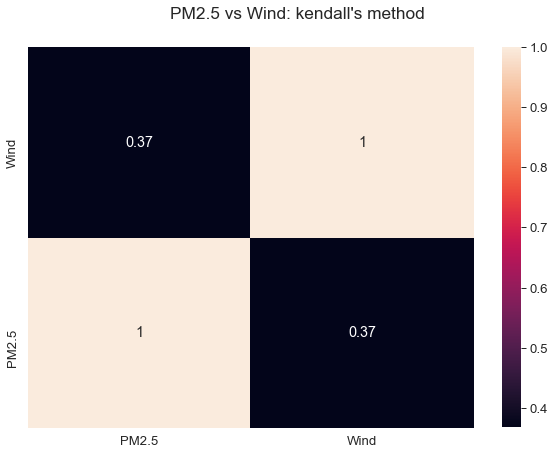

In [17]:
# Plot PM2.5 vs Wind with Kendall’s method.
plot_corr("PM2.5", "Wind", "kendall")

<br>

* __SO2__

In [18]:
# Calculate correlation between SO2 and Wind Speed.
correlation("SO2", "Wind")

Pearson’s r: 0.06, p-value: 0.79
Spearman’s rho: -0.04, p-value: 0.84
Kendall’s tau: -0.04, p-value: 0.82


None of the above results are statistically significant.

<br>

* __O3__

In [19]:
# Calculate correlation between O3 and Wind Speed.
correlation("O3", "Wind")

Pearson’s r: 0.67, p-value: 0.00
Spearman’s rho: 0.77, p-value: 0.00
Kendall’s tau: 0.62, p-value: 0.00


All three coefficients are showing strong positive correlation between O3 and wind speed and since the p-value in all three cases is 0.00 the results are statistically highly significant. 

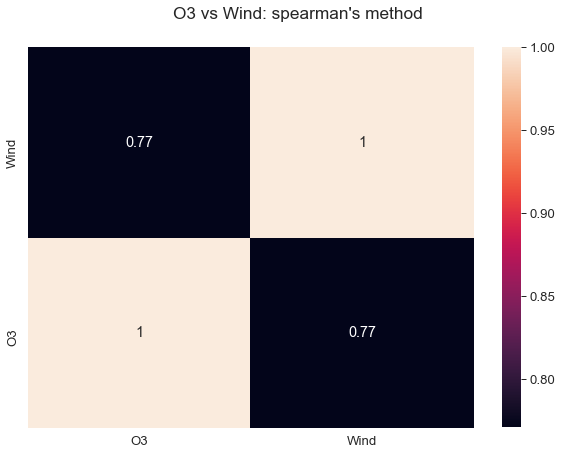

In [20]:
# Plot O3 vs Wind with Spearman’s method.
plot_corr("O3", "Wind", "spearman")

<br>

* __AQI__

Since only PM10, PM2.5 and O3 are positively correlated with wind speed and AQI is derived from pollutant variables, it is logical to assume that AQI will show weak or moderate positive correlation with wind speed. Let's see if our assumptions are valid.

In [21]:
# Calculate correlation between AQI and Wind Speed.
correlation("AQI", "Wind")

Pearson’s r: 0.00, p-value: 0.99
Spearman’s rho: 0.33, p-value: 0.12
Kendall’s tau: 0.34, p-value: 0.04


As expected, in these results we have an indicator of a moderate positive relationship between the variables, however, the only statistically significant is Kendall’s tau.

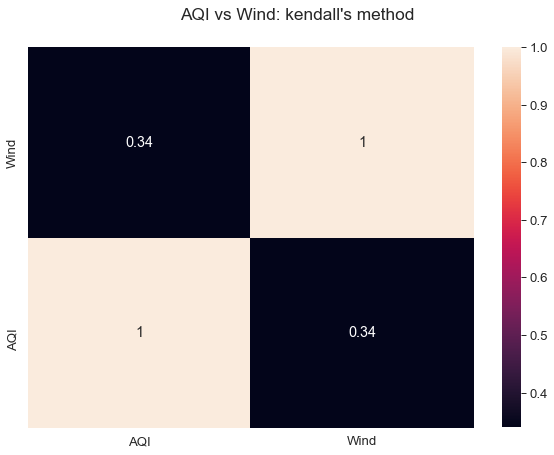

In [22]:
# Plot AQI vs Wind with Kendall’s method.
plot_corr("AQI", "Wind", "kendall")

<br>

### Distribution Fitting <a name=" dist_fitting"></a>
___

<br>

In fitting data on air pollution, there are many acceptable distribution models depending on the areas of study. For example, according to International Journal of Engineering & Technology among the most used distributions are: 
* gamma, 
* lognormal,
* weibull,
* beta,
* gumble.  [16]

However, this is according only to one source. In order to find which distribution fits best our data we should evaluate the list of available distributions and then perform test _The Goodness of Fit_. Below I will be using a widely used option _Kolmogorov–Smirnov test_. [17] [18] 

> [16] [International Journal of Engineering & Technology: Fitting Statistical Distribution on Air Pollution: An Overview](https://www.researchgate.net/publication/329267591_Fitting_Statistical_Distribution_on_Air_Pollution_An_Overview)
<br>
[17] [Medium: Distribution Fitting with Python SciPy](https://medium.com/@amirarsalan.rajabi/distribution-fitting-with-python-scipy-bb70a42c0aed)
<br>
[18] [Stack OVerflow: Distribution Fitting with Sum of Square Error (SSE)](https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python?lq=1)

In [23]:
def fit_dist(data):
    
    """ Fitting distributions function. 
        Performs K-S test and sorts results by lowest stats 
    """
    # List of 87 distribution available on Scipy.
    list_of_dists = ['alpha','anglit','arcsine','beta','betaprime','bradford','burr','burr12','cauchy','chi','chi2','cosine','dgamma','dweibull','erlang','expon','exponnorm','exponweib','exponpow','f','fatiguelife','fisk','foldcauchy','foldnorm','frechet_r','frechet_l','genlogistic','genpareto','gennorm','genexpon','genextreme','gausshyper','gamma','gengamma','genhalflogistic','gilbrat','gompertz','gumbel_r','gumbel_l','halfcauchy','halflogistic','halfnorm','halfgennorm','hypsecant','invgamma','invgauss','invweibull','johnsonsb','johnsonsu','kstwobign','laplace','levy','levy_l','logistic','loggamma','loglaplace','lognorm','lomax','maxwell','mielke','nakagami','ncx2','ncf','nct','norm','pareto','pearson3','powerlaw','powerlognorm','powernorm','rdist','reciprocal','rayleigh','rice','recipinvgauss','semicircular','t','triang','truncexpon','truncnorm','tukeylambda','uniform','vonmises','vonmises_line','wald','weibull_min','weibull_max']

    # Create an empty list.
    results = []

    # Loop through each distribution.
    for i in list_of_dists:
        dist = getattr(stats, i)
        # Fit it to the data.
        param = dist.fit(df[data])
        # Perform Kolmogorov–Smirnov test.
        a = stats.kstest(df[data], i, args=param)
        # Append results to the list.
        results.append((i,a[0],a[1]))

    # Sort results by the lowest statistic.
    results.sort(key=lambda x:float(x[2]), reverse=True)
    # Return only first 5 results.
    for j in results[:5]:
        # Print results.
        print(f"{j[0]}: statistic={j[1]}, pvalue={j[2]}")

In [24]:
def make_pdf(dist, params, size=1000):
    """Generate distributions's Probability Distribution Function """
    # Separate parts of parameters.
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get start and end points of distribution.
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas series.
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

In [25]:
def plot_data_with_pdf_fitted(data, dist):
    """Plot generation """
    # Fit distribution.
    params = dist.fit(df[data])
    
    # Call the function to make PDF
    pdf = make_pdf(dist, params)
    
    # Plot it
    ax = pdf.plot(lw=2, label='PDF', legend=True)
    
    # Plot the data on the same axis.
    df[data].plot(kind='hist', density=True, title=data, alpha=0.5, label='Data', legend=True, ax=ax)
    
    # Show the plot.
    plt.show()

<br>

* __AQI__ 

In [26]:
%%capture --no-stdout

# Fit distributions to AQI.
fit_dist("AQI")

laplace: statistic=0.17604399988392794, pvalue=0.40301060386742177
johnsonsu: statistic=0.18763881490496703, pvalue=0.32619168218993855
hypsecant: statistic=0.18963645012427643, pvalue=0.31409709896584626
loglaplace: statistic=0.18993290789719824, pvalue=0.3123302416861034
foldcauchy: statistic=0.1951248865529729, pvalue=0.28254596858308056


We can see that __laplace__ distribution will fit AQI data best. Let's import the distribution and then buid a plot.

In [27]:
# Import laplace distribution.
from scipy.stats import laplace

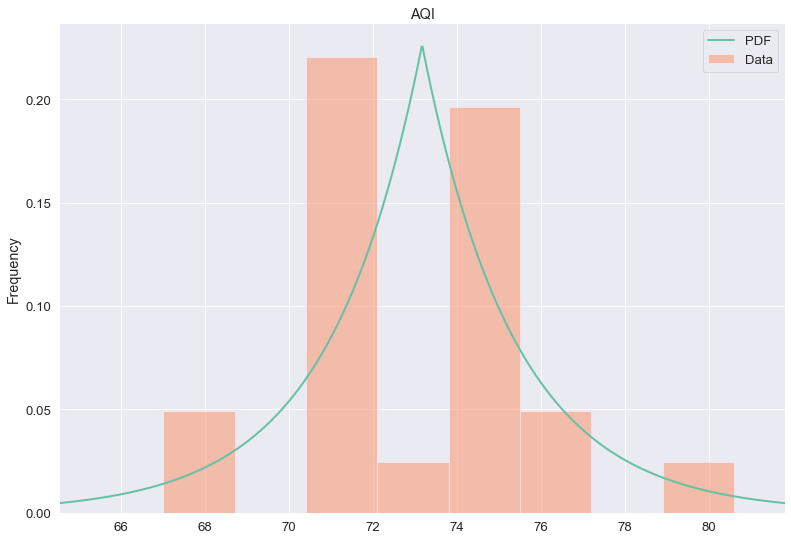

In [28]:
# Plot AQI with laplace distribution fitted.
plot_data_with_pdf_fitted("AQI", laplace)

<br>

* __NO2__ 

In [29]:
%%capture --no-stdout

# Fit distributions to NO2.
fit_dist("NO2")

pearson3: statistic=0.11006390814551326, pvalue=0.9332460865429394
chi2: statistic=0.11006421114138942, pvalue=0.93324471072411
gamma: statistic=0.11006468221121257, pvalue=0.9332425716971462
erlang: statistic=0.11006485134136934, pvalue=0.9332418037039794
recipinvgauss: statistic=0.11601677955935441, pvalue=0.9032022624029075


For NO2 the best fitting distribution is __pearson3__.

In [30]:
# Import pearson3 distribution.
from scipy.stats import pearson3

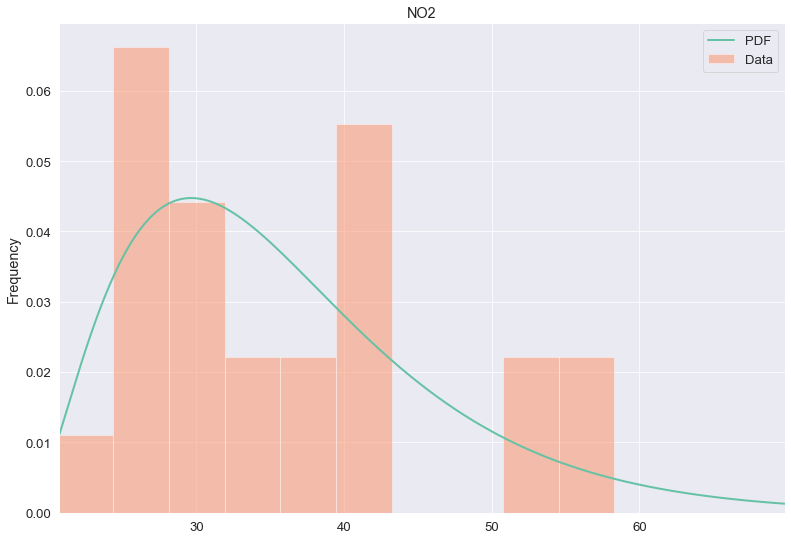

In [31]:
# Plot NO2 with pearson3 distribution fitted.
plot_data_with_pdf_fitted("NO2", pearson3)

<br>

* __PM10__ 

In [32]:
%%capture --no-stdout

# Fit distributions to PM10.
fit_dist("PM10")

johnsonsb: statistic=0.09105533900868285, pvalue=0.9885954557380542
gausshyper: statistic=0.09302889934088848, pvalue=0.9855190203001372
beta: statistic=0.1035661252634218, pvalue=0.9590356769977738
uniform: statistic=0.11044657097288674, pvalue=0.931495801760645
powerlognorm: statistic=0.1154080644025332, pvalue=0.9065439772526485


In [33]:
# Import johnsonsb distribution.
from scipy.stats import johnsonsb

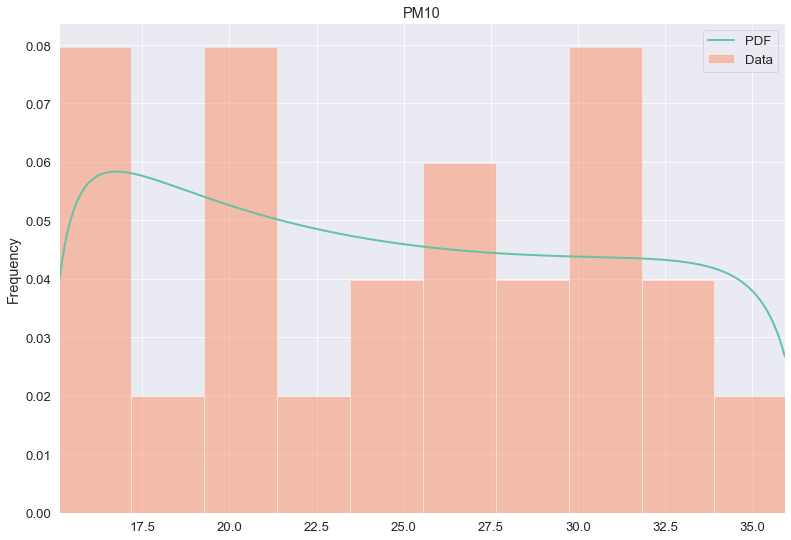

In [34]:
# Plot PM10 with johnsonsb distribution fitted.
plot_data_with_pdf_fitted("PM10", johnsonsb)

<br>

* __PM2.5__ 

In [35]:
%%capture --no-stdout

# Fit distributions to PM2.5.
fit_dist("PM2.5")

laplace: statistic=0.14704364175048057, pvalue=0.6451409498854047
johnsonsu: statistic=0.14848966917551953, pvalue=0.6314147682634358
dweibull: statistic=0.15195030567570417, pvalue=0.5992480777974585
hypsecant: statistic=0.15195934006760087, pvalue=0.5991653771571748
foldcauchy: statistic=0.15610214243695786, pvalue=0.5619504957324818


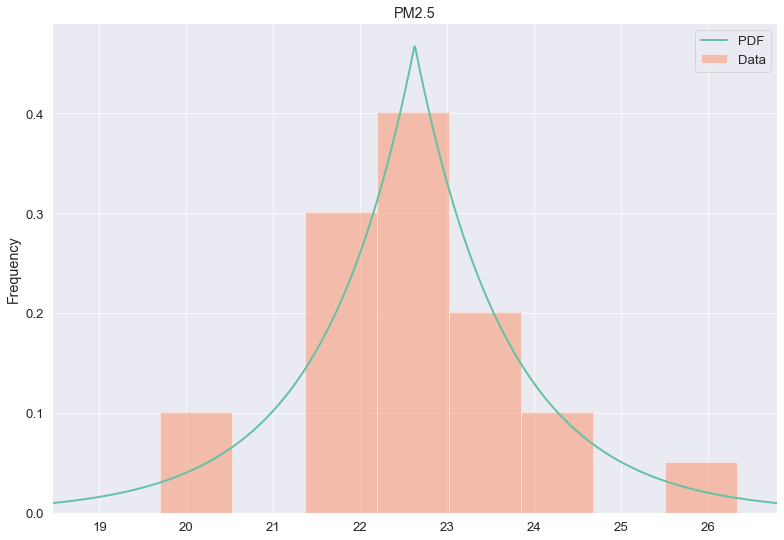

In [36]:
# Plot PM2.5 with laplace distribution fitted.
plot_data_with_pdf_fitted("PM2.5", laplace)

<br>

* __SO2__

In [37]:
%%capture --no-stdout

# Fit distributions to SO2.
fit_dist("SO2")

johnsonsb: statistic=0.10194551012256223, pvalue=0.9643092926613047
lomax: statistic=0.10641180753942803, pvalue=0.948658871247563
expon: statistic=0.10652674009879692, pvalue=0.9482096914869441
exponnorm: statistic=0.10717876478344746, pvalue=0.945617203103064
powerlognorm: statistic=0.11466944979525151, pvalue=0.9105184917981277


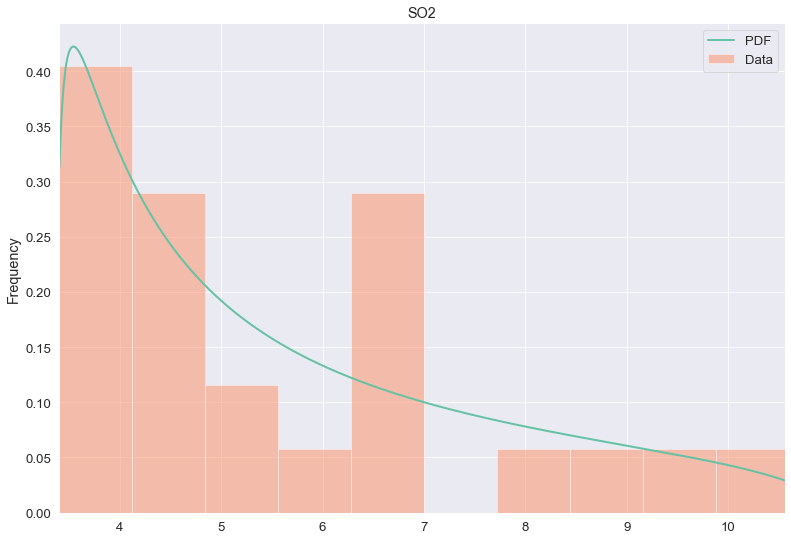

In [38]:
# Plot SO2 with johnsonsb distribution fitted.
plot_data_with_pdf_fitted("SO2", johnsonsb)

<br>

* __O3__

In [39]:
%%capture --no-stdout

# Fit distributions to O3.
fit_dist("O3")

johnsonsu: statistic=0.12959299579061723, pvalue=0.8150251481869092
burr12: statistic=0.13028551739783517, pvalue=0.8099394526570176
nct: statistic=0.13128755837776368, pvalue=0.8025013304820159
foldcauchy: statistic=0.13165209561000235, pvalue=0.7997729763714215
fisk: statistic=0.13280729715523304, pvalue=0.7886746967568071


In [40]:
# Import johnsonsu distribution.
from scipy.stats import johnsonsu

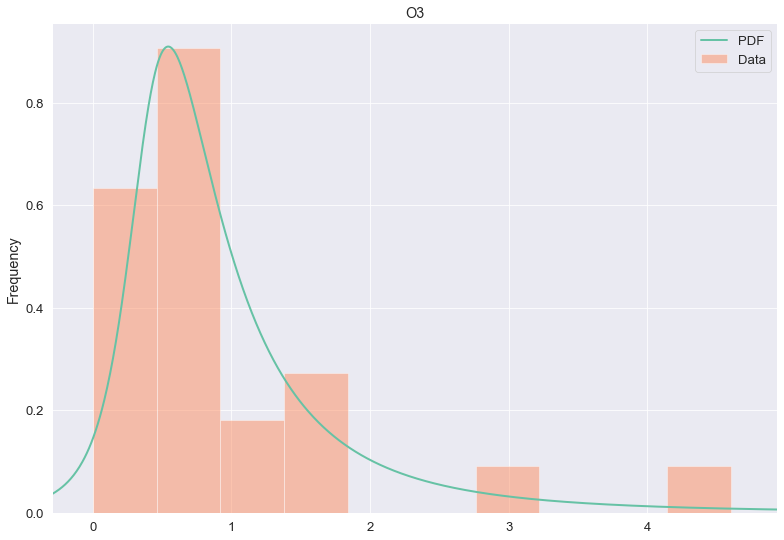

In [41]:
# Plot O3 with johnsonsu distribution fitted.
plot_data_with_pdf_fitted("O3", johnsonsu)

<br>

* __Wind Speed__

In [42]:
%%capture --no-stdout

# Fit distributions to Wind.
fit_dist("Wind")

johnsonsb: statistic=0.16838867342838484, pvalue=0.46002426320186907
dweibull: statistic=0.1690128430985166, pvalue=0.4551875281914068
powerlaw: statistic=0.17054327497168503, pvalue=0.443469227822424
nakagami: statistic=0.1744468553474331, pvalue=0.4144901007243314
lomax: statistic=0.176770222244926, pvalue=0.3978632742012152


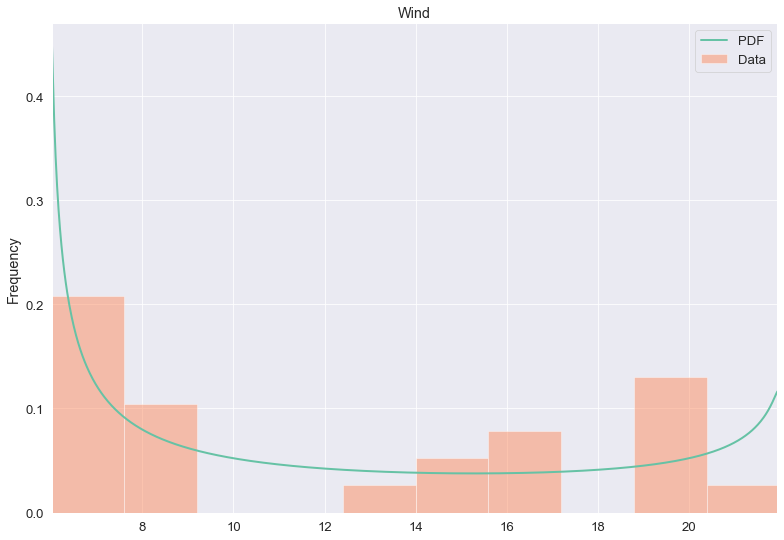

In [43]:
# Plot Wind with johnsonsb distribution fitted.
plot_data_with_pdf_fitted("Wind", johnsonsb)

<br>

* __Wind Direction__

To fit distribution for Wind direction, which is a categorical variable, we would need to convert it first into numerical. One way of doing it is by representing each wind direction with a label. [19]

> [19] [Dataquest: Add a Column to a Pandas DataFrame Based on an If-Else Condition](https://www.dataquest.io/blog/tutorial-add-column-pandas-dataframe-based-on-if-else-condition/)

In [44]:
# Create a list of conditions.
conditions = [
    (df["Wind Direction"] == "west"),
    (df["Wind Direction"] == "north west"),
    (df["Wind Direction"] == "north east"),
    (df["Wind Direction"] == "north")
    ]

# Create a list of the labels.
labels = [1, 2, 3, 4]

# Create a new column and assign labels to it.
df['Wind Label'] = np.select(conditions, labels)

# Display updated DataFrame.
df.head()

,AQI,NO2,PM2.5,PM10,O3,SO2,Wind,Wind Direction,Wind Label
2020-12-07 00:00:00,84,32.1,28.0,36.0,1.0,5.0,9,west,1
2020-12-07 01:00:00,74,29.7,23.0,33.0,0.4,4.2,9,west,1
2020-12-07 02:00:00,74,28.5,23.0,28.1,0.8,4.1,9,west,1
2020-12-07 03:00:00,72,26.9,22.1,21.2,0.4,3.9,7,north west,2
2020-12-07 04:00:00,72,26.1,22.2,21.5,0.3,3.7,7,north west,2


In [45]:
%%capture --no-stdout

# Fit distributions to Wind labels.
fit_dist("Wind Label")

logistic: statistic=0.24142820449267516, pvalue=0.10244332453327641
hypsecant: statistic=0.2491736529357969, pvalue=0.08461868451991382
t: statistic=0.2654720429661786, pvalue=0.05545266588484421
vonmises_line: statistic=0.2690613481454875, pvalue=0.05033580140236773
maxwell: statistic=0.275122865906662, pvalue=0.04261187867515177


In [46]:
# Import logistic distribution.
from scipy.stats import logistic

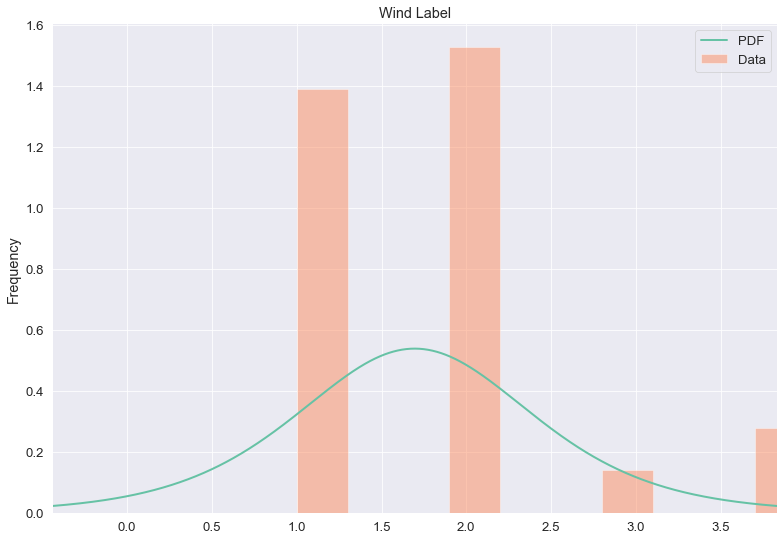

In [47]:
# Plot Wind labels with cauchy distribution fitted.
plot_data_with_pdf_fitted("Wind Label", logistic)

<br>

### Data Simulation <a name="data_simulation"></a>
___

<br>

Now that we know what distributions fit our variables best, we can draw samples for each variable. [20] 

Data is simulated for 56 days, or 1344 hours, till the end of winter counting from 07/12/2020 inclusively.


> [20] [Kite: How to convert a 2D NumPy array to a 1D array in Python](https://www.kite.com/python/answers/how-to-convert-a-2d-numpy-array-to-a-1d-array-in-python)

<br>

* __NO2__

In [48]:
# Drawing samples from pearson3 distribution.
# Create an empty list.
val_sim = []

# Draw samples 56 times
n = 56

# Loop through to add 24 samples in each iteration.
for i in range(n):
    # Get parameters.
    a, loc, scale = pearson3.fit(df["NO2"])
    # Draw samples.
    day_val = pearson3.rvs(a, scale = scale, loc=loc, size = 24)
    val_sim.append(day_val)

# Convert into 1D array.
no2_s = np.array(val_sim).flatten()

<br>

* __PM10, SO2, O3, Wind__

In [49]:
def draw_val_johnson(data, distr):
    """ Drawing samples from johnsonsb and johnsonsu distributions """
    val_sim = []
    for i in range(n):
        # Get parameters.
        a,b, loc, scale = distr.fit(df[data])
        # Draw samples.
        day_val = distr.rvs(a, b, scale = scale, loc=loc, size = 24)
        val_sim.append(day_val)
    return val_sim

In [50]:
# Draw samples for Wind, SO2, PM10, O3.
wind_s = draw_val_johnson("Wind", johnsonsb)
so2_s = draw_val_johnson("SO2", johnsonsb)
pm10_s = draw_val_johnson("PM10", johnsonsb)
o3_s = draw_val_johnson("O3", johnsonsu)

# Convert into 1D array.
wind_s = np.array(wind_s).flatten()
so2_s = np.array(so2_s).flatten()
pm10_s = np.array(pm10_s).flatten()
o3_s = np.array(o3_s).flatten()

<br>

* __AQI, PM2.5, Wind Direction__

In [51]:
def draw_val_l_l(data, distr):
    """ Drawing samples from laplace and logistic distributions """
    val_sim = []
    for i in range(n):
        # Get parameters.
        loc, scale = distr.fit(df[data])
        # Draw samples.
        day_val = distr.rvs(scale = scale, loc=loc, size = 24)
        val_sim.append(day_val)
    return val_sim

In [52]:
# Draw samples for AQI, PM2.5 and Wind labels.
aqi_s = draw_val_l_l("AQI", laplace)
pm25_s = draw_val_l_l("PM2.5", laplace)
wd_s = draw_val_l_l("Wind Label", logistic)

# Convert into 1D array.
aqi_s = np.array(aqi_s).flatten()
pm25_s = np.array(pm25_s).flatten()
wd_s = np.array(wd_s).flatten()

<br> 

* __Time__

In [53]:
# Simulate the date range for 1344 hours.
rng_s = pd.date_range('12/07/2020', periods=1344, freq='H')

<br>

### Simulated Data Set <a name="new_ds"></a>
___

<br>

The next step is to gather all simulated data and create a new data set.

In [75]:
# Create a Dataframe from simulated values.
df_s = pd.DataFrame({"AQI": aqi_s,
                     "NO2": no2_s,
                     "PM10": pm10_s,
                     "PM2.5": pm25_s,
                     "SO2": so2_s,
                     "O3": o3_s,
                     "Wind": wind_s,
                     "Wind Label": wd_s
                     }, index=rng_s)

# Display the new data set.
df_s.head()

,AQI,NO2,PM10,PM2.5,SO2,O3,Wind,Wind Label
2020-12-07 00:00:00,73.036762,30.234048,28.239714,19.951252,3.670916,0.013731,16.847861,1.687002
2020-12-07 01:00:00,72.636149,23.312984,31.514969,22.710633,4.894058,1.231270,6.061204,3.494499
2020-12-07 02:00:00,65.821350,23.885627,22.942856,22.284186,4.514131,0.824481,8.414629,2.533776
2020-12-07 03:00:00,70.739852,33.020271,30.580018,21.744843,4.821748,0.216020,9.405959,2.566649
2020-12-07 04:00:00,76.494444,27.969988,18.946585,22.649760,3.838705,0.925891,6.228289,0.569036


As our data for pollution and wind speed must be non-negative, we would need to check if this condition is satisfied. [21]

> [21] [Stack Overflow: Python Pandas: DataFrame filter negative values](https://stackoverflow.com/questions/24214941/python-pandas-dataframe-filter-negative-values)

In [55]:
# Check for negative values.
(df_s > 0).all()

AQI            True
NO2            True
PM10           True
PM2.5          True
SO2            True
O3            False
Wind           True
Wind Label    False
dtype: bool

Simulated O3 and Wind Labels appear to have negative values. 

First let's correct this issue for O3 values. One way of doing this is by getting its absolute values. [22]

> [22] [Stack Overflow: Python numpy.random.normal only positive values](https://stackoverflow.com/questions/16312006/python-numpy-random-normal-only-positive-values)

In [56]:
# Get an absolute value for each O3 value.
new_o3 = abs(df_s["O3"])

# Replace O3 column with new values.
df_s['O3'] = new_o3

<br>

Now to Wind Labels. We can opt for the same method we used when converting categorical values Wind Direction to Wind Labels.

In [57]:
# Create a list of conditions.
conditions = [
    (df_s["Wind Label"] <= 1.5),
    (df_s["Wind Label"] > 1.5) & (df_s["Wind Label"] <= 2.5),
    (df_s["Wind Label"] > 2.5) & (df_s["Wind Label"] <= 3.5),
    (df_s["Wind Label"] > 3.5)
    ]

# Create a list of the Wind labels (as originally 4).
new_labels = [1, 2, 3, 4]

# Create a new column and assign directions to it.
df_s['Wind Label'] = np.select(conditions, new_labels)

# Check for negative values again.
(df_s > 0).all()

AQI           True
NO2           True
PM10          True
PM2.5         True
SO2           True
O3            True
Wind          True
Wind Label    True
dtype: bool

<br>

### Comparison between Simulated and Original data sets <a name="comparison"></a>
___

<br>

Now we can compare the simulated data set with the original. First we can do so by plotting all values from the data sets. [23]

> [23] [Stack Overflow: Drawing average line in histogram (matplotlib)](https://stackoverflow.com/questions/16180946/drawing-average-line-in-histogram-matplotlib)

<br>

#### Visualization <a name="vis"></a>

<br> 

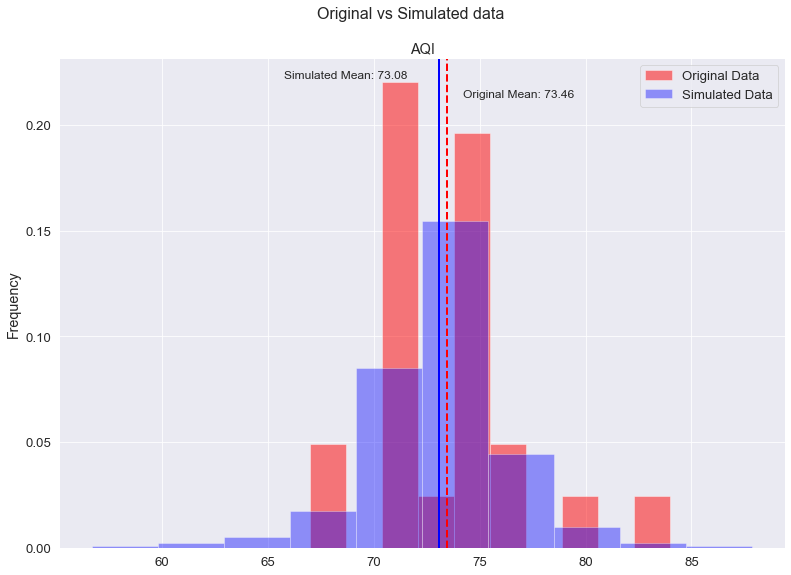

In [58]:
def original_data(data, a1, b1):
    ''' Function for plotting original data'''
    # Build a plot.
    df[data].plot(kind='hist', density=True, title=data, alpha=0.5, label='Original Data', color="Red", legend=True, ax=ax)
    ax.axvline(df[data].mean(), color='r', linestyle='dashed', linewidth=2)
    # Select minimum and maximum y limits to use in text on axis.
    min_ylim, max_ylim = plt.ylim()
    ax.text(df[data].mean()*a1, max_ylim*b1, f'Original Mean: {df[data].mean():.2f}', fontsize=12)
    
def simulated_data(data, a2, b2):
    ''' Function for plotting simulated data'''
    # Build plots for data and mean.
    df_s[data].plot(kind='hist', title=data, density=True, alpha=0.4, label='Simulated Data', color="Blue", legend=True, ax=ax)
    ax.axvline(df_s[data].mean(), color='b', linewidth=2)
    # Select minimum and maximum y limits to use in text on axis.
    min_ylim, max_ylim = plt.ylim()
    ax.text(df_s[data].mean()*a2, max_ylim*b2, f'Simulated Mean: {df_s[data].mean():.2f}', fontsize=12)
    
def compare_plots(data, a1, b1, a2, b2):
    ''' Calling original and simulated data plotting'''
    # Set a title.
    fig.suptitle("Original vs Simulated data", y=0.96, fontsize=16)    
    original_data(data, a1, b1)
    simulated_data(data, a2, b2)
    

# Create a figure and axis.
fig, ax = plt.subplots(figsize=(13, 9))

# Plot AQI.
compare_plots("AQI", 1.01, 0.92, 0.9, 0.96)

# Show the plot.
plt.show()

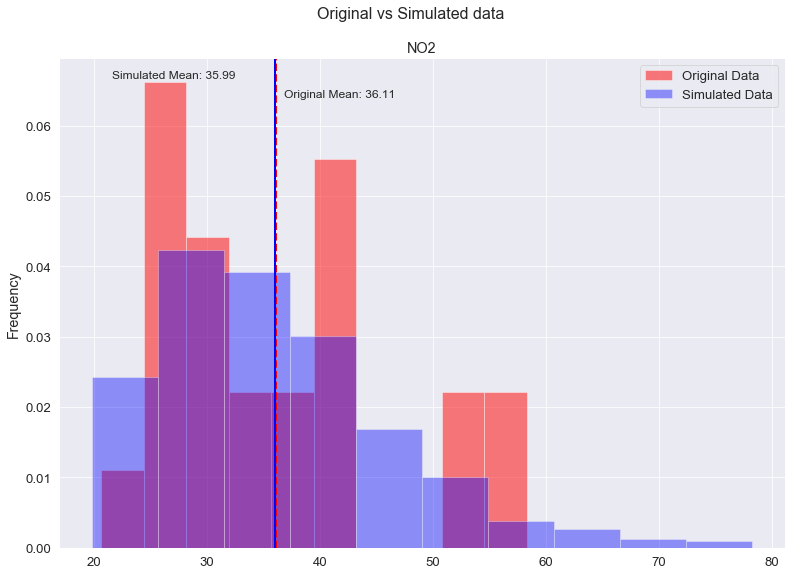

In [59]:
# Create a figure and axis.
fig, ax = plt.subplots(figsize=(13, 9))

# Plot NO2.
compare_plots('NO2', 1.02, 0.92, 0.6, 0.96)

# Show the plot.
plt.show()

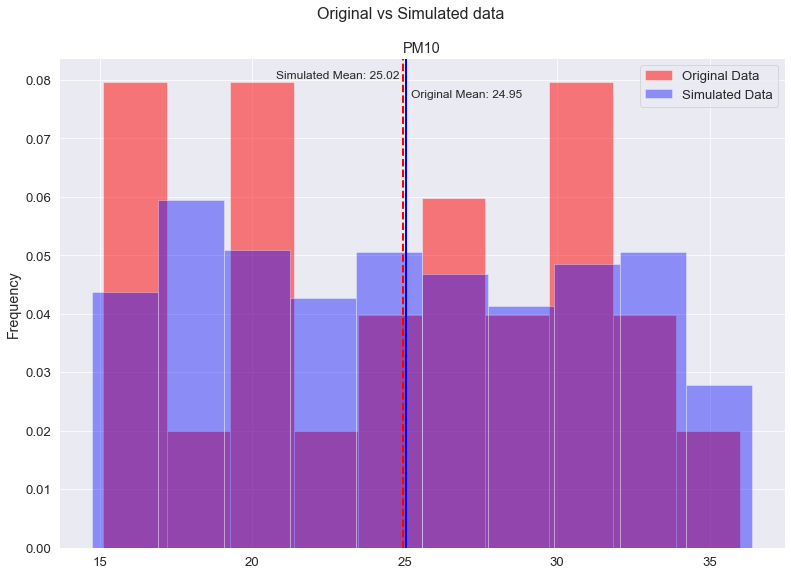

In [60]:
# Create a figure and axis.
fig, ax = plt.subplots(figsize=(13, 9))

# Plot PM10.
compare_plots('PM10', 1.01, 0.92, 0.83, 0.96)

# Show the plot.
plt.show()

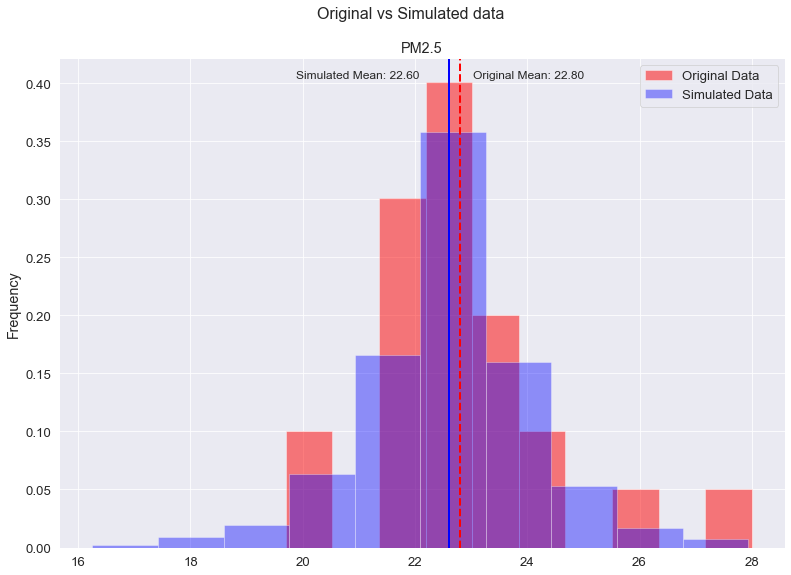

In [61]:
# Create a figure and axis.
fig, ax = plt.subplots(figsize=(13, 9))

# Plot PM2.5.
compare_plots('PM2.5', 1.01, 0.96, 0.88, 0.96)

# Show the plot.
plt.show()

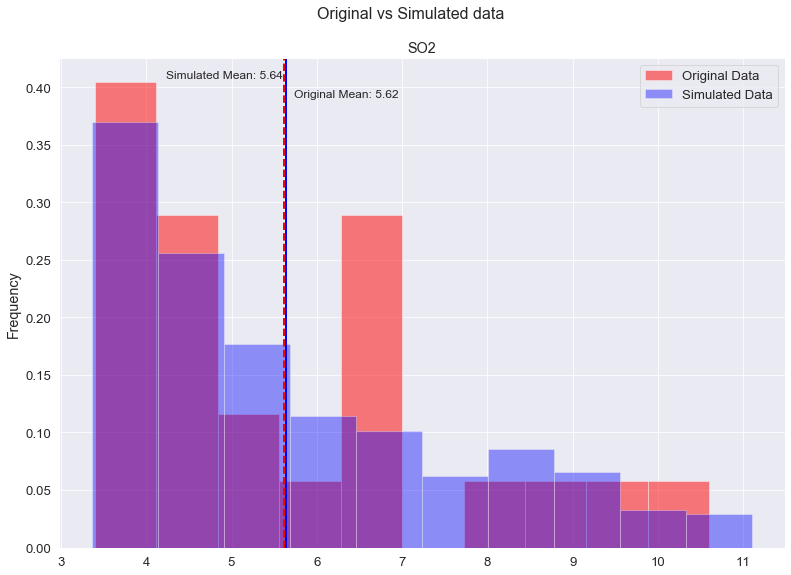

In [62]:
# Create a figure and axis.
fig, ax = plt.subplots(figsize=(13, 9))

# Plot SO2.
compare_plots('SO2', 1.02, 0.92, 0.75, 0.96)

# Show the plot.
plt.show()

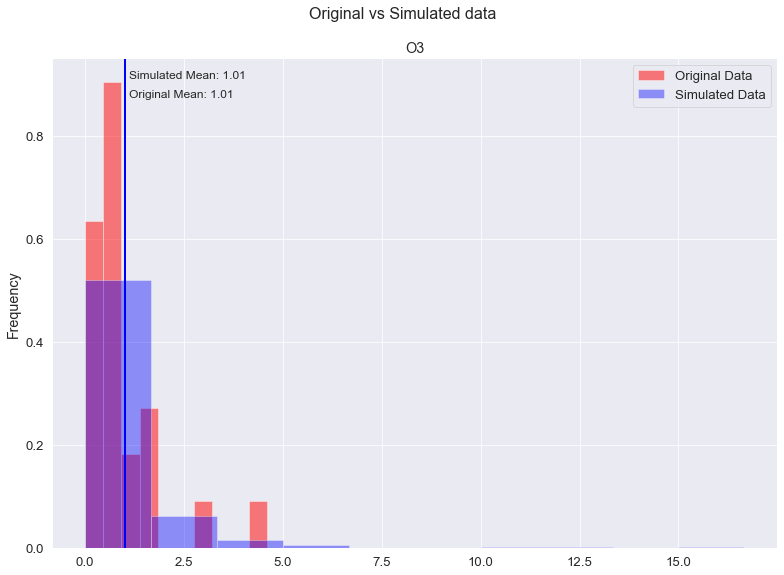

In [63]:
# Create a figure and axis.
fig, ax = plt.subplots(figsize=(13, 9))

# Plot O3.
compare_plots('O3', 1.1, 0.92, 1.1, 0.96)

# Show the plots.
plt.show()

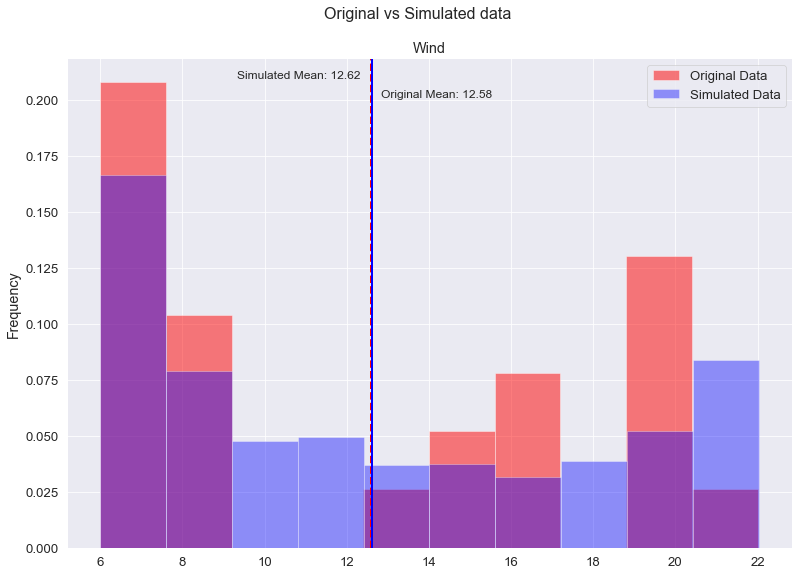

In [64]:
# Create a figure and axis.
fig, ax = plt.subplots(figsize=(13, 9))

# Plot Wind.
compare_plots("Wind", 1.02, 0.92, 0.74, 0.96)

# Show the plot.
plt.show()

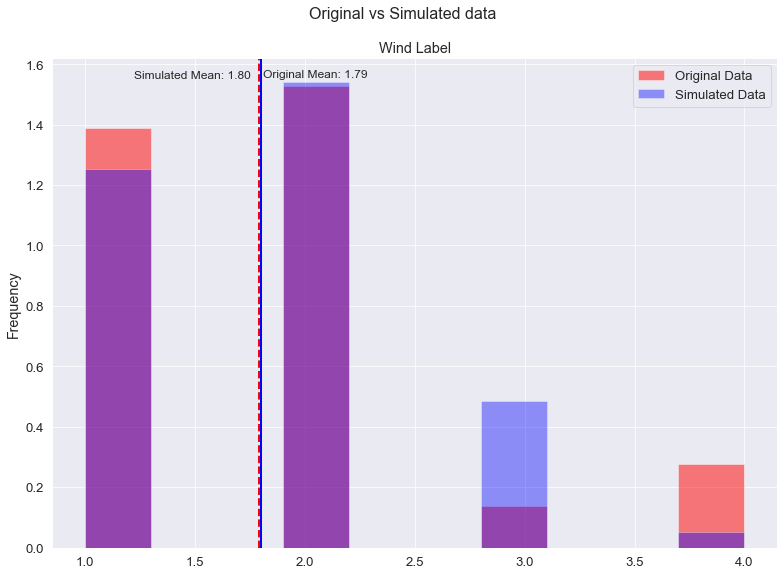

In [65]:
# Create a figure and axis.
fig, ax = plt.subplots(figsize=(13, 9))

# Plot Wind Label.
compare_plots("Wind Label", 1.01, 0.97, 0.68, 0.96)

# Show the plot.
plt.show()

The above plots illustrate that our simulated data is well matched, however, not pefect.

<br>

#### Mean <a name="mean"></a>

<br>

To compare means we can perform _independent samples t-test_ - it will determine whether there is a statistically significant difference between the means in our data sets.

In [66]:
# Select 7th December in the simulated data set.
df_s.loc["2020-12-07 00:00:00": "2020-12-07 23:00:00"]

,AQI,NO2,PM10,PM2.5,SO2,O3,Wind,Wind Label
2020-12-07 00:00:00,73.036762,30.234048,28.239714,19.951252,3.670916,0.013731,16.847861,2
2020-12-07 01:00:00,72.636149,23.312984,31.514969,22.710633,4.894058,1.231270,6.061204,3
2020-12-07 02:00:00,65.821350,23.885627,22.942856,22.284186,4.514131,0.824481,8.414629,3
2020-12-07 03:00:00,70.739852,33.020271,30.580018,21.744843,4.821748,0.216020,9.405959,3
2020-12-07 04:00:00,76.494444,27.969988,18.946585,22.649760,3.838705,0.925891,6.228289,1
2020-12-07 05:00:00,72.840831,44.487661,20.204398,23.980183,4.222355,0.159248,22.008558,1
2020-12-07 06:00:00,66.359767,38.288029,36.305151,20.799490,3.375304,4.059199,9.966749,1
2020-12-07 07:00:00,69.839926,35.557098,33.946081,21.665588,4.142956,0.449244,11.887304,2
2020-12-07 08:00:00,75.414232,30.433013,23.953295,20.665590,7.475179,0.458993,16.455055,2
2020-12-07 09:00:00,73.233664,30.101461,34.591720,23.091923,4.982405,0.562460,6.159386,2


In [76]:
# Loo through each numerical column.
for i in df_s.columns:
    # Perform t-test.
    t_ss, p_ss = stats.ttest_ind(df[i], df_s[i])
    # Print results.
    print(f"{i}'s P_value: {p_ss:0.2f}")

AQI's P_value: 0.55
NO2's P_value: 0.95
PM10's P_value: 0.95
PM2.5's P_value: 0.52
SO2's P_value: 0.96
O3's P_value: 0.93
Wind's P_value: 0.97
Wind Label's P_value: 0.69


As p_value is above 0.05 we can say that we can reject the null hypotesis. Where p-value 1 indicates at identical means in the data sets, it appears that the best simulated data are NO2, PM10, SO2, O3 and Wind data. However, we should check for Type II errors False Negatives before concluding if our results are valid.

In [83]:
# Check for False Negatives.
trials = 10000
dont = 0
critical = 0.05

# Loo through each numerical column.
for i in df_s.columns:
    for j in range(trials):
        if stats.ttest_ind(df[i], df_s[i])[1] <= critical:
            dont = dont + j
    # Calculate false negatives.
    typeii = 100.0 * (dont / trials)
    # Print results.
    print(f"{i} : {typeii:0.2f}%")

AQI : 0.00%
NO2 : 0.00%
PM10 : 0.00%
PM2.5 : 0.00%
SO2 : 0.00%
O3 : 0.00%
Wind : 0.00%
Wind Label : 0.00%


It seems that there is no Type II errors in our calculations, thus, we can confirm results of performing the t-tests.

<br>

#### Variance <a name="variance"></a>

<br>

<br>

### Final adjustments <a name="adj"></a>
___

<br>

Lastly, we can reverse Wind labels back to their categorical values. The working assumption here is that there are only _west, north west, north east and north_ wind directions during winter in Dublin.

In [68]:
# Create a list of conditions.
conditions = [
    (df_s["Wind Label"] == 1),
    (df_s["Wind Label"] == 2),
    (df_s["Wind Label"] == 3),
    (df_s["Wind Label"] == 4)
    ]

# Create a list of the Wind directions.
directions = ["west", "north west", "north east", "north"]

# Create a new column and assign directions to it.
df_s['Wind Direction'] = np.select(conditions, directions)

# Drop column Wind Label.
simulated_ds = df_s.drop(["Wind Label"],axis=1)

# Display updated DataFrame.
simulated_ds

,AQI,NO2,PM10,PM2.5,SO2,O3,Wind,Wind Direction
2020-12-07 00:00:00,73.036762,30.234048,28.239714,19.951252,3.670916,0.013731,16.847861,north west
2020-12-07 01:00:00,72.636149,23.312984,31.514969,22.710633,4.894058,1.231270,6.061204,north east
2020-12-07 02:00:00,65.821350,23.885627,22.942856,22.284186,4.514131,0.824481,8.414629,north east
2020-12-07 03:00:00,70.739852,33.020271,30.580018,21.744843,4.821748,0.216020,9.405959,north east
2020-12-07 04:00:00,76.494444,27.969988,18.946585,22.649760,3.838705,0.925891,6.228289,west
...,...,...,...,...,...,...,...,...
2021-01-31 19:00:00,76.205657,27.347864,34.775427,22.519984,6.307455,1.096302,16.614065,west
2021-01-31 20:00:00,77.545794,45.508570,21.124766,21.291092,5.480755,0.163924,17.925484,west
2021-01-31 21:00:00,69.938574,49.356595,17.779600,23.581046,4.316305,1.296937,6.297191,west
2021-01-31 22:00:00,73.287918,33.398685,21.587397,22.625594,4.360159,1.187487,19.942175,north west


<br>

___

### End